# Time-Series Research Project

- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [2]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

In [3]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#yf.pdr_override()
%matplotlib inline

In [4]:
import pandas as pd

# Fetch NVIDIA data (Scaled using Min-Max Scaler with relevant columns (Open, High, Low, Close, Adjusted Close, and Volume) normalized to values between 0 and 1)
dataset = yf.download('NVDA', start='2010-01-01', end='2024-08-28')

# Display the first few rows
print(dataset.head())

# Save the data to a CSV file
dataset.to_csv('nvidia_stock_data.csv')


[*********************100%***********************]  1 of 1 completed

               Open    High      Low    Close  Adj Close     Volume
Date                                                               
2010-01-04  0.46275  0.4655  0.45275  0.46225   0.423923  800204000
2010-01-05  0.46050  0.4740  0.46050  0.46900   0.430113  728648000
2010-01-06  0.46875  0.4730  0.46425  0.47200   0.432864  649168000
2010-01-07  0.46950  0.4715  0.45925  0.46275   0.424381  547792000
2010-01-08  0.45900  0.4670  0.45625  0.46375   0.425298  478168000


In [5]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Nvidia stock price")
    plt.show()

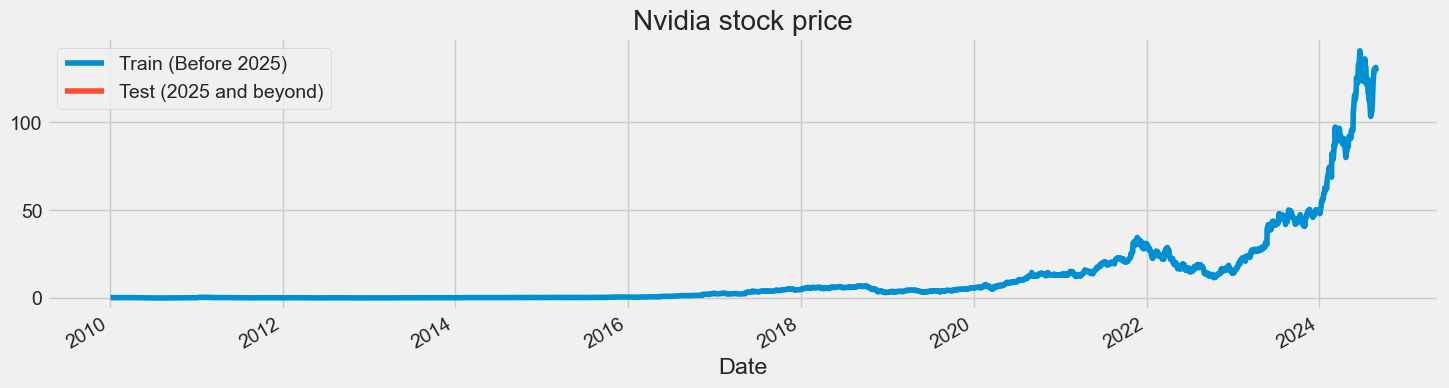

In [6]:
tstart = 2010
tend = 2024

train_test_plot(dataset, tstart, tend)

# Create train and test datasets

In [7]:
# Check the column names in the dataset to ensure 'Date' is present
print(dataset.columns)

# Reload the dataset, ensuring the 'Date' column is there
dataset = pd.read_csv('nvidia_stock_data.csv')

# Convert 'Date' to datetime if necessary
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set 'Date' as the index
dataset.set_index('Date', inplace=True)

# Verify the columns after processing
print(dataset.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [8]:
# Adjust the train_test_split function to use proper date strings and index
def train_test_split(dataset, train_start, train_end, columns=['High']):
    train = dataset.loc[train_start:train_end, columns].values
    test = dataset.loc[train_end:, columns].values
    return train, test

# Set correct date ranges for training and testing
train_start = '2010-01-01'
train_end = '2021-12-31'

# Split the data
training_set, test_set = train_test_split(dataset, train_start, train_end)

# Check the sizes of the training and test sets
print(f"Training set size: {len(training_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 3021
Test set size: 667


# Scaling dataset values

In [9]:
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set = training_set.reshape(-1, 1)
# training_set_scaled = sc.fit_transform(training_set)

# Initialize the MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
training_set_scaled = sc.fit_transform(training_set)

# Scale the test data
test_set_scaled = sc.transform(test_set)

# Creating overlapping window batches

In [10]:
n_steps = 60
features = 1

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
# Reshape into X=t and Y=t+1
# Split the training and test data into sequences
X_train, y_train = split_sequence(training_set_scaled, n_steps)
X_test, y_test = split_sequence(test_set_scaled, n_steps)

# Reshape the input data to 3D (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluation

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,6))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize = (10,6))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

# Calculate Mean Squared Error (MSE)
def return_mse(y_test_scaled, predicted_stock_price):
    mse = mean_squared_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Squared Error: {mse:.2f}")

# Calculate Mean Absolute Error (MAE)
def return_mae(y_test_scaled, predicted_stock_price):
    mae = mean_absolute_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Absolute Error: {mae:.2f}")

# Calculate Root Mean Squared Error (RMSE)
def return_rmse(y_test_scaled, predicted_stock_price):
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_stock_price))
    print(f"Root Mean Squared Error: {rmse:.2f}")

# Calculate Mean Absolute Percentage Error (MAPE)
def return_mape(y_test_scaled, predicted_stock_price):
    mape = np.mean(np.abs((y_test_scaled - predicted_stock_price) / y_test_scaled)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Recurrent Neural Network **(RNN)**

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0314 - val_loss: 2.0992
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0277 - val_loss: 1.7890
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0220 - val_loss: 1.4867
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0168 - val_loss: 1.2046
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0147 - val_loss: 0.9168
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0100 - val_loss: 0.6676
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0080 - val_loss: 0.4539
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0046 - val_loss: 0.3075
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - val_loss: 0.1929
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.1213
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0776
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

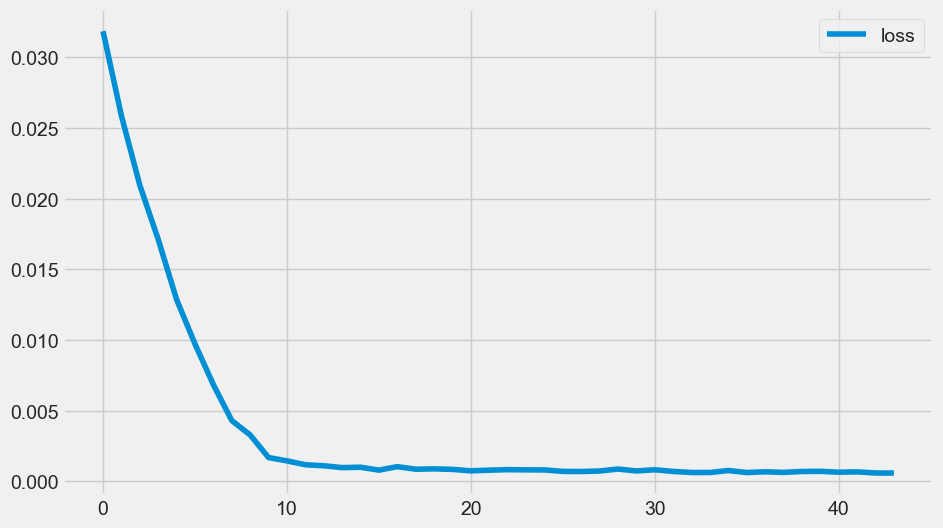

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


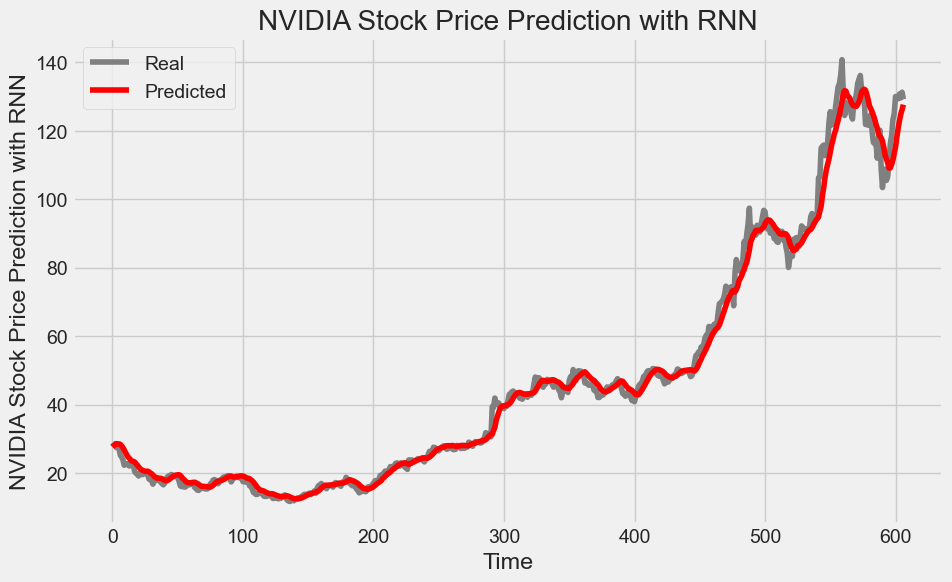

In [13]:
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Adjust hyperparameters for fine-tuning
units = 150  # Number of RNN units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.000005  # Further reduce learning rate
epochs = 200  # Increase number of epochs

# Build the refined RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_rnn.add(Dropout(dropout_rate))  # Add regularization
model_rnn.add(SimpleRNN(units=units, activation='relu'))
model_rnn.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices
predicted_stock_price = model_rnn.predict(X_test)

# Inverse transform the predicted stock prices to reverse scaling values to the original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Inverse transform the y_test values (real stock prices)
y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))

plot_predictions(y_test_scaled, predicted_stock_price, "NVIDIA Stock Price Prediction with RNN")

### Calculate the error for different evaluation metrics

In [15]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price)

Mean Squared Error: 7.97
Mean Absolute Error: 1.76
Root Mean Squared Error: 2.82
Mean Absolute Percentage Error: 3.90%


### RNN Conclusion

#### Evaluation Metrics:

- Mean Squared Error (MSE = 7.97): 

This is a very low value compared to previous versions, indicating that the squared errors between the predicted and actual stock prices have reduced significantly.

- Mean Absolute Error (MAE = 1.76): 

On average, the model’s predictions are only $2 off from the actual stock prices, which is a very strong performance for stock price prediction.

- Root Mean Squared Error (RMSE = 2.82): 

This tells us that, on average, the model’s predictions are off by about $2.82. RMSE is slightly more sensitive to larger errors, but this value is still very small.

- Mean Absolute Percentage Error (MAPE = 3.90%): 

A MAPE of 3.90% is excellent for stock price forecasting, where values below 5% are considered highly accurate.

#### Interpretation:

The graph looks quite good as the model closely follows the actual stock prices, with only minor deviations. The performance is particularly strong during periods of stable growth, and even during more volatile periods, the model tracks the overall trend well.

The error metrics (especially MAE and MAPE) indicate that the model is making very accurate predictions, with minimal error in terms of both absolute values (dollars) and relative percentage.

# Long-short Term Model **(LSTM)**

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0139 - val_loss: 0.4424
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 4.5099e-04 - val_loss: 0.0493
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 3.6813e-04 - val_loss: 0.0226
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.8183e-04 - val_loss: 0.0159
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 2.2548e-04 - val_loss: 0.0127
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.7658e-04 - val_loss: 0.0453
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.5433e-04 - val_loss: 0.0303
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.1118e-04 - val_loss: 0.0352
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 1.7922e-04 - val_loss: 0.0529
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.0537e-04 - val_loss: 0.0704
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 1.7757e-04 - val_loss: 0.0813
Epoch 12/200

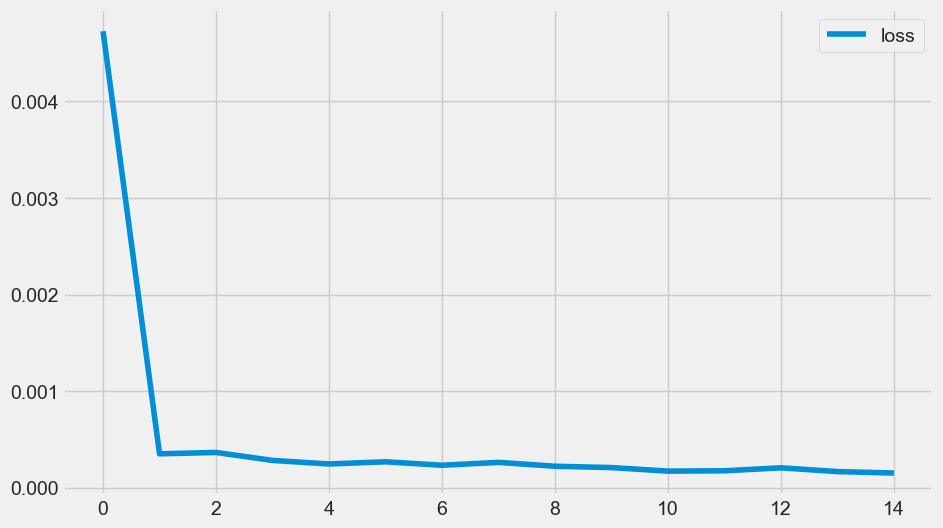

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


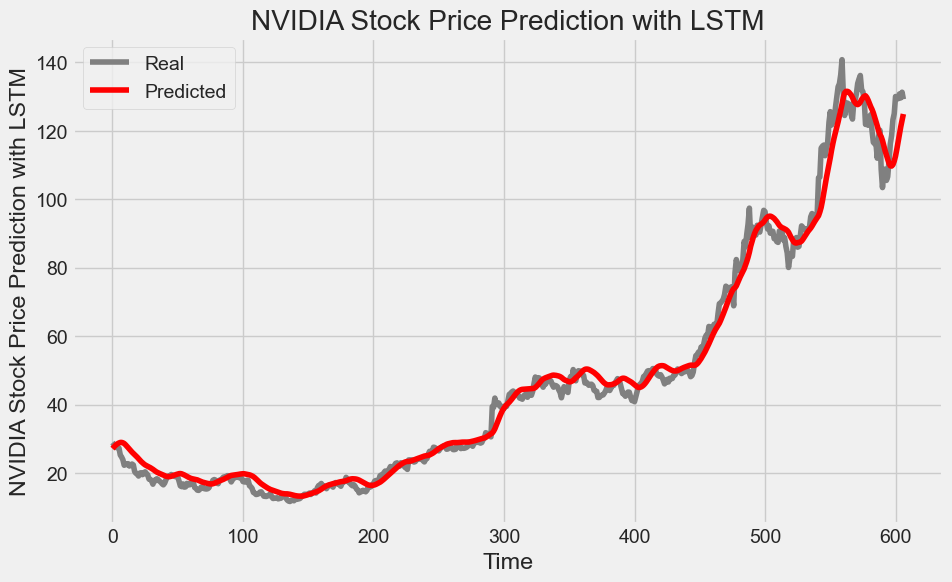

In [15]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 30
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=learning_rate)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [16]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 15.08
Mean Absolute Error: 2.71
Root Mean Squared Error: 3.88
Mean Absolute Percentage Error: 6.86%


### Initial LSTM Conclusion

We are getting worse results than our RNN model, so I will experiment with swapping the optimizer and implementing a version of the LSTM model without Early Stopping

### LSTM with RMSprop optimizer

We'll try using the RMSprop optimizer, which often works well with recurrent neural networks like LSTM. RMSprop adapts the learning rate based on recent gradients, which can be beneficial for time series data.

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0136 - val_loss: 0.0924
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 4.1227e-04 - val_loss: 0.2585
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 4.0961e-04 - val_loss: 0.0486
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 4.7573e-04 - val_loss: 0.0932
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 3.3337e-04 - val_loss: 0.0488
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 3.4193e-04 - val_loss: 0.0555
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 3.3358e-04 - val_loss: 0.0313
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 2.9363e-04 - val_loss: 0.0293
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 2.6305e-04 - val_loss: 0.0275
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 3.7356e-04 - val_loss: 0.0262
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 3.1507e-04 - val_loss: 0.0266
Epoch 12/200
93/93 ━━━━

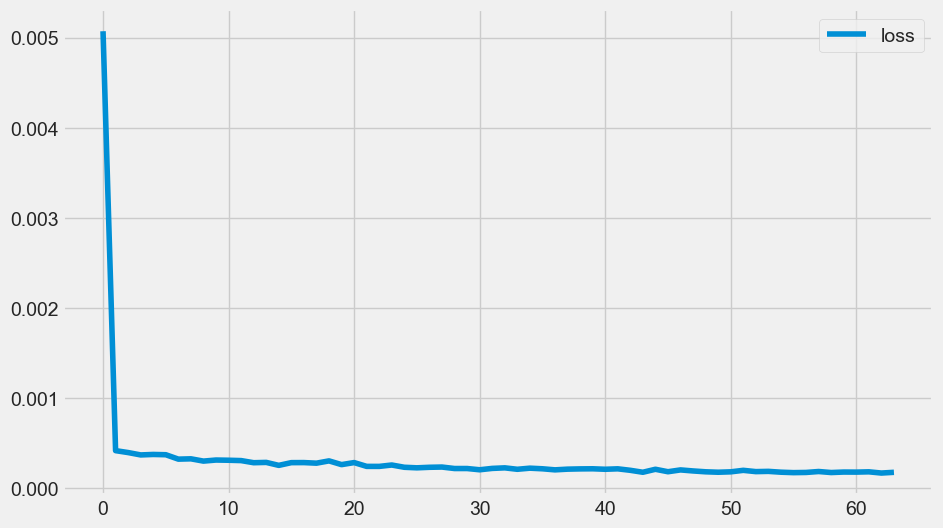

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


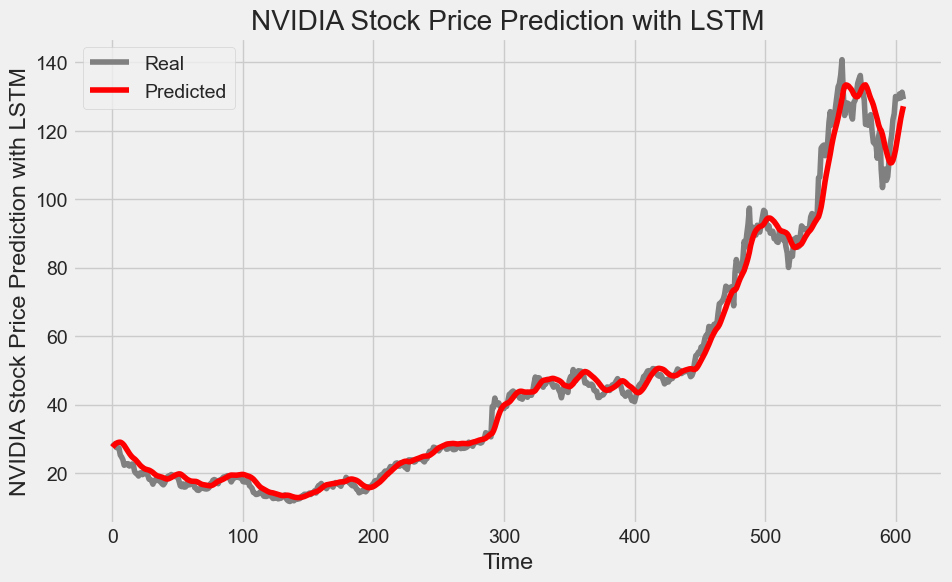

In [18]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps 30
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning .0002
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = RMSprop(learning_rate=learning_rate)  # Using RMSprop instead of Adam
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [20]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 13.37
Mean Absolute Error: 2.43
Root Mean Squared Error: 3.66
Mean Absolute Percentage Error: 5.67%


### LSTM with RMSprop optimizer without Early Stopping

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 0.0163 - val_loss: 0.1107
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 4.2393e-04 - val_loss: 0.0523
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 3.3812e-04 - val_loss: 0.1402
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 3.6174e-04 - val_loss: 0.0462
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 4.5296e-04 - val_loss: 0.0576
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 3.2792e-04 - val_loss: 0.0480
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 4.0300e-04 - val_loss: 0.0337
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 3.2003e-04 - val_loss: 0.0365
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 3.0830e-04 - val_loss: 0.0349
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 2.8034e-04 - val_loss: 0.0264
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 3.1513e-04 - val_loss: 0.0268
Ep

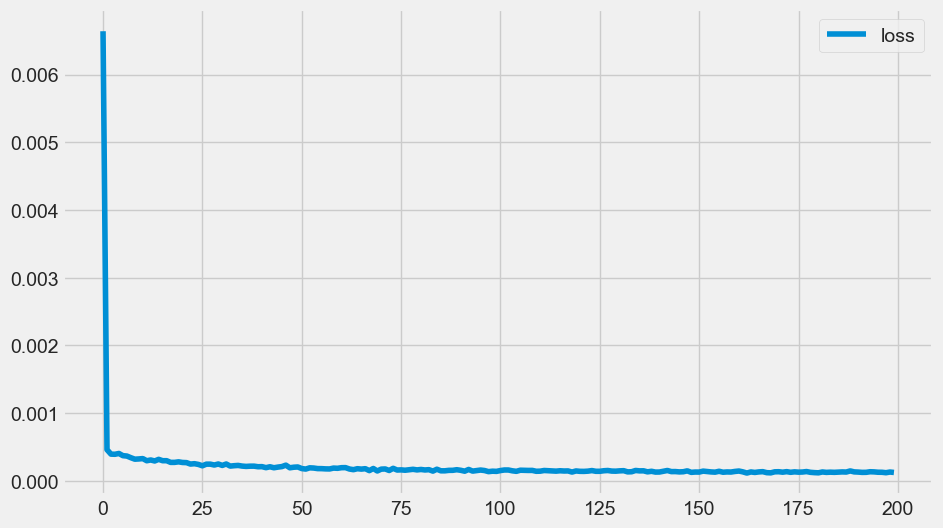

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


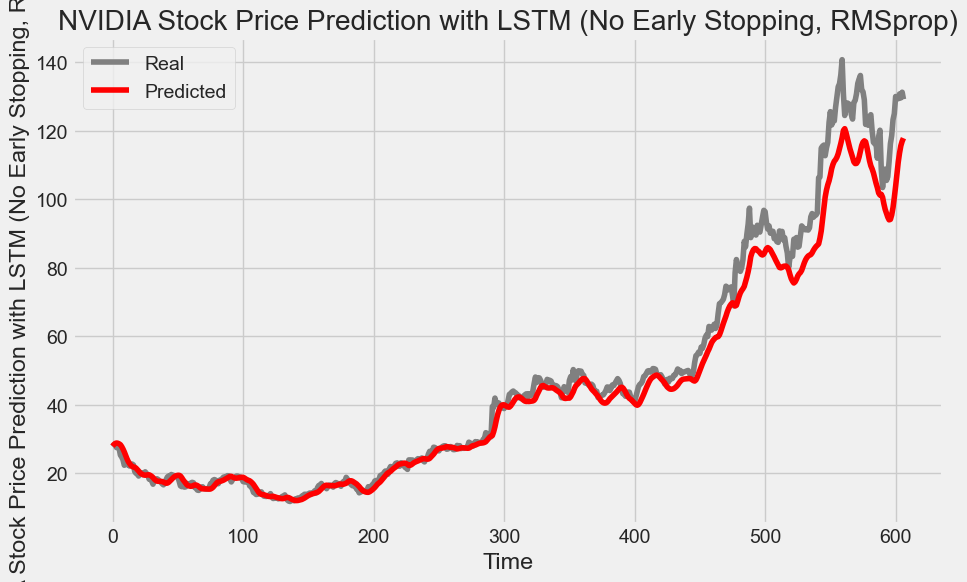

In [63]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop  # Change optimizer to RMSprop

# Set the hyperparameters for the LSTM model
n_steps = 150
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with RMSprop optimizer and a specified learning rate
optimizer = RMSprop(learning_rate=learning_rate)  # Using RMSprop instead of Adam
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the LSTM model without early stopping
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                         validation_data=(X_test, y_test))  # No early stopping

# Plot training and validation loss
plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

# Plot predictions against actual stock prices
plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM (No Early Stopping, RMSprop)")


In [64]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 40.97
Mean Absolute Error: 3.79
Root Mean Squared Error: 6.40
Mean Absolute Percentage Error: 6.10%


### Second LSTM Conclusion

The results suggest that RMSprop indeed improves performance over Adam for the LSTM in this stock prediction task. The version with early stopping has achieved the best results, with relatively low MSE, MAE, RMSE, and MAPE values compared to the version without early stopping.

This finding aligns with the typical use of RMSprop for recurrent networks, as it adapts the learning rate dynamically and can handle sequence data more effectively than Adam in some cases. Early stopping also helps prevent overfitting, allowing the model to generalize better without exhaustively fitting to the training data.

### LSTM with different Optimizers

We'll experiment with Nadam, Adagrad, Adadelta, SGD with Momentum, and AMSGrad optimizers to see if they perform better than RMSprop

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0118 - val_loss: 0.3515
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 3.1933e-04 - val_loss: 0.0172
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 3.3917e-04 - val_loss: 0.0413
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 2.4628e-04 - val_loss: 0.0294
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 2.0158e-04 - val_loss: 0.0582
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.7416e-04 - val_loss: 0.0576
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 2.1803e-04 - val_loss: 0.0613
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.5439e-04 - val_loss: 0.0509
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.2476e-04 - val_loss: 0.0675
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.3238e-04 - val_loss: 0.0294
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.6055e-04 - val_loss: 0.1424
Ep

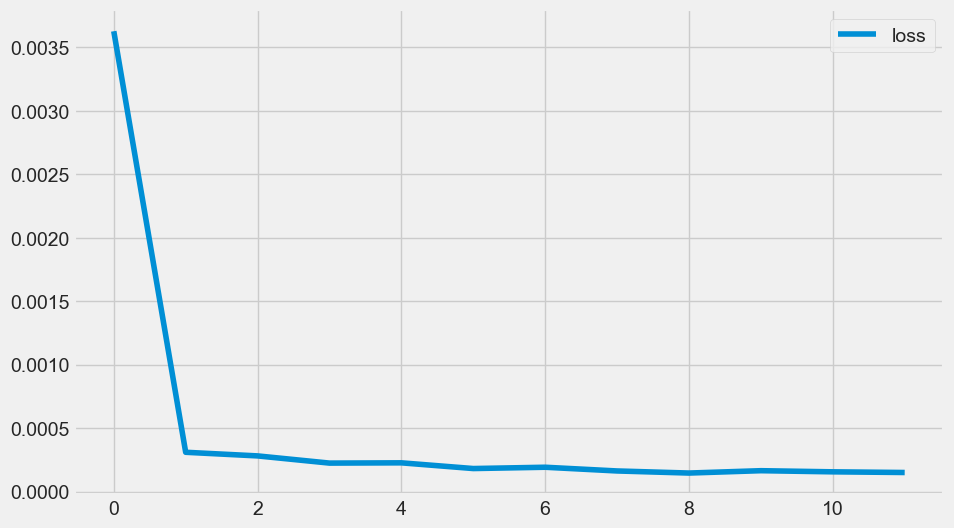

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


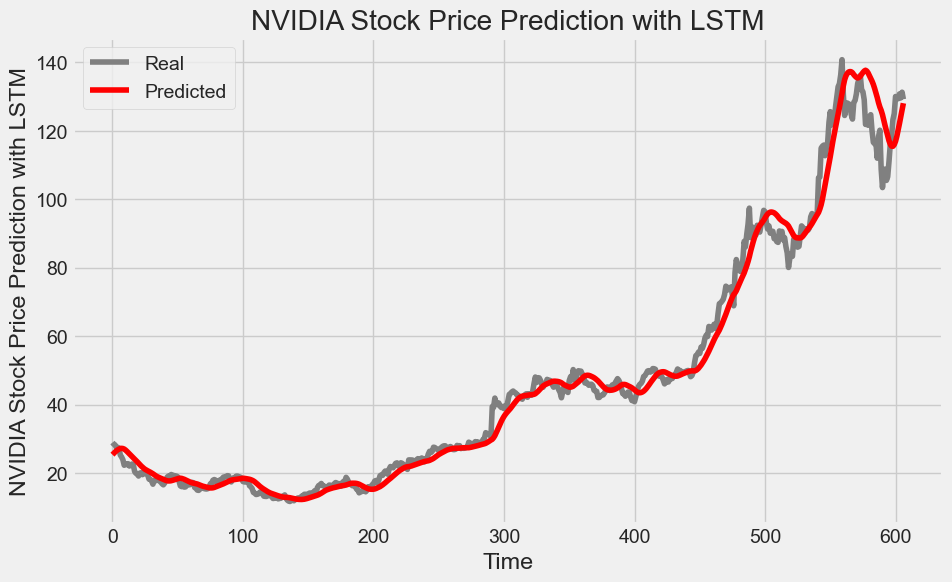

In [65]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Nadam(learning_rate=0.0003)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [66]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 20.38
Mean Absolute Error: 2.99
Root Mean Squared Error: 4.51
Mean Absolute Percentage Error: 6.64%


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.0384 - val_loss: 2.6877
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0377 - val_loss: 2.5916
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0310 - val_loss: 2.5198
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0271 - val_loss: 2.4623
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0273 - val_loss: 2.4140
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0261 - val_loss: 2.3720
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0238 - val_loss: 2.3330
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0234 - val_loss: 2.2978
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0246 - val_loss: 2.2651
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0232 - val_loss: 2.2320
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0217 - val_loss: 2.2007
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

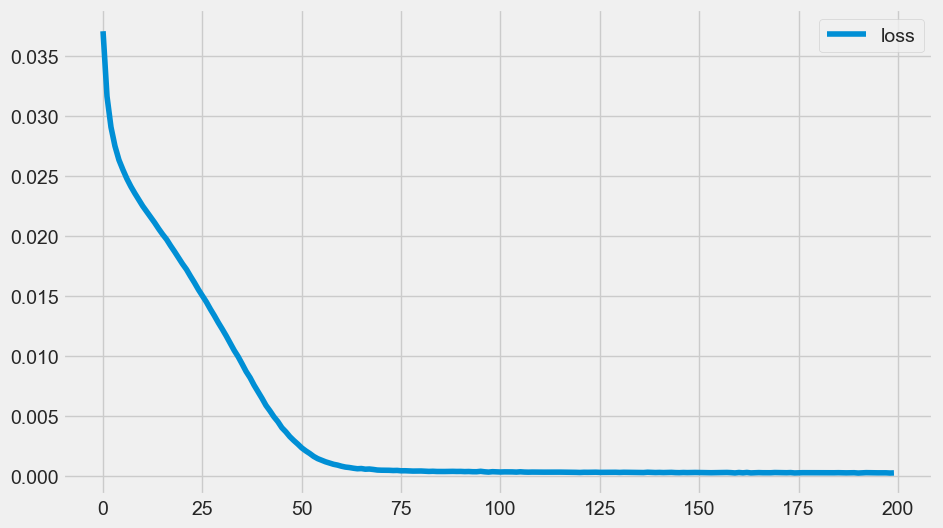

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


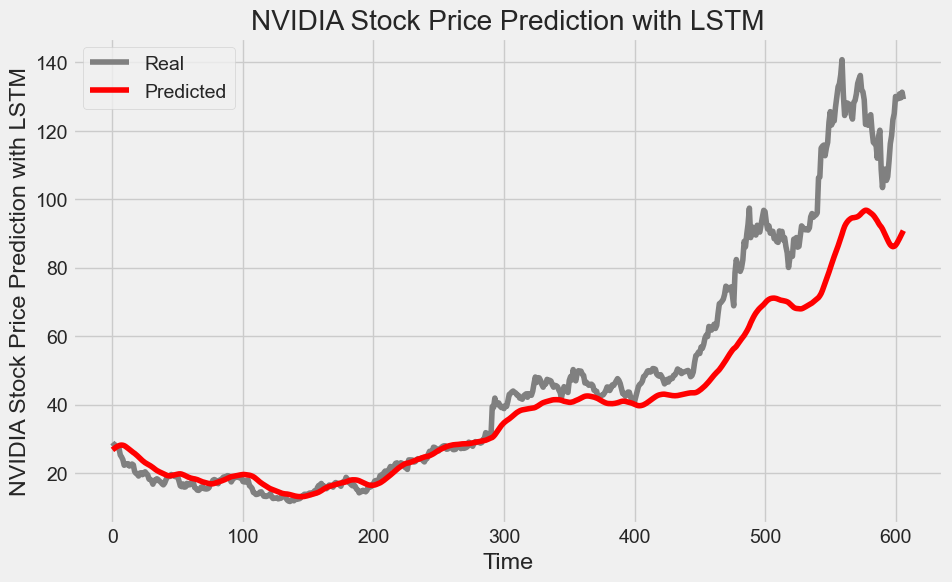

In [67]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adagrad(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [68]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 208.64
Mean Absolute Error: 8.85
Root Mean Squared Error: 14.44
Mean Absolute Percentage Error: 13.86%


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 0.0165 - val_loss: 0.0318
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 5.4883e-04 - val_loss: 0.0263
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 3.9130e-04 - val_loss: 0.0236
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 5.0034e-04 - val_loss: 0.0269
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 4.2187e-04 - val_loss: 0.0236
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 4.6285e-04 - val_loss: 0.0211
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 5.4459e-04 - val_loss: 0.0345
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 3.5027e-04 - val_loss: 0.0341
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 4.8426e-04 - val_loss: 0.0223
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 3.1800e-04 - val_loss: 0.0198
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 3.6415e-04 - val_loss: 0.0204
Ep

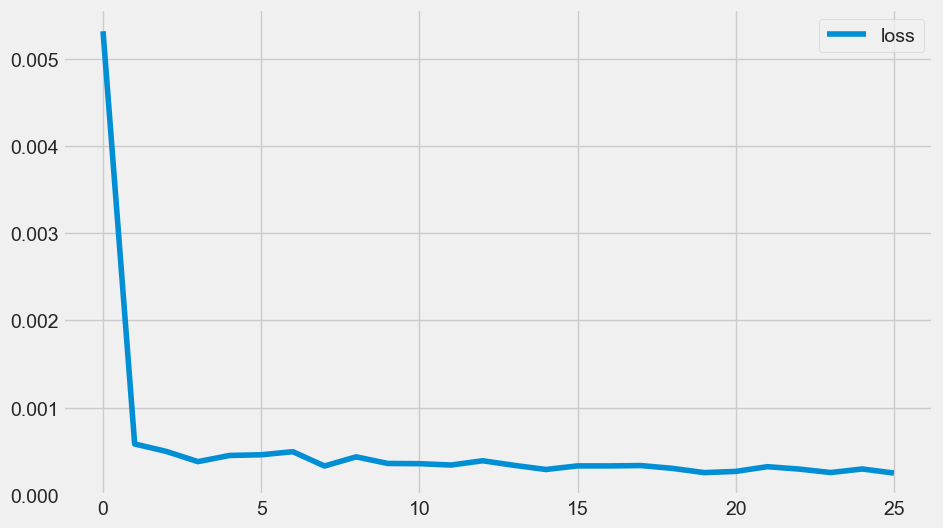

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


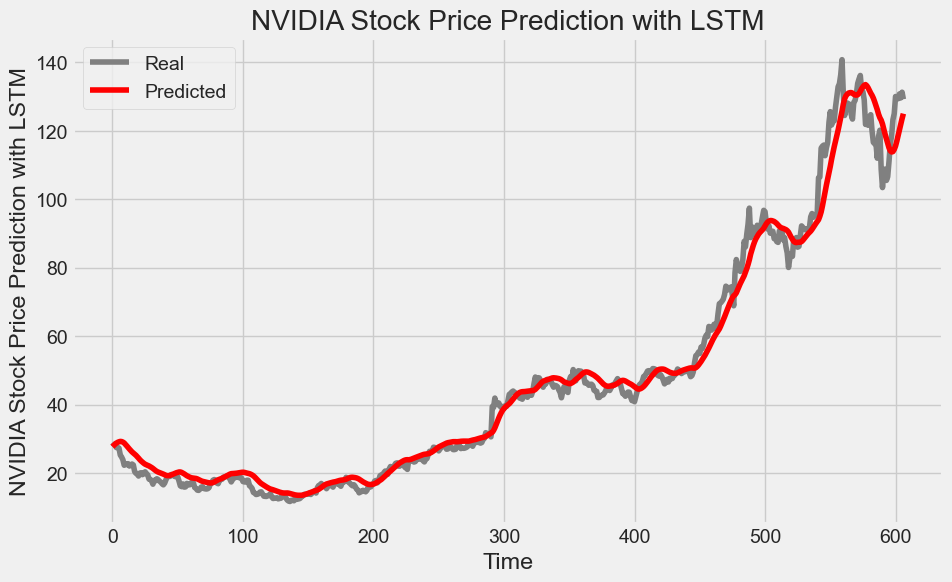

In [69]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adadelta(learning_rate=1.0)  # Default is often effective
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [70]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 18.84
Mean Absolute Error: 2.97
Root Mean Squared Error: 4.34
Mean Absolute Percentage Error: 7.38%


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.0270 - val_loss: 1.6515
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0074 - val_loss: 0.4783
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 5.0525e-04 - val_loss: 0.3204
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 3.4276e-04 - val_loss: 0.2805
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 3.9185e-04 - val_loss: 0.2606
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 2.6069e-04 - val_loss: 0.2411
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 2.8150e-04 - val_loss: 0.2345
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 2.8216e-04 - val_loss: 0.2217
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 2.4182e-04 - val_loss: 0.2068
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 2.3539e-04 - val_loss: 0.2007
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 2.6005e-04 - val_loss: 0.1980
Epoch 

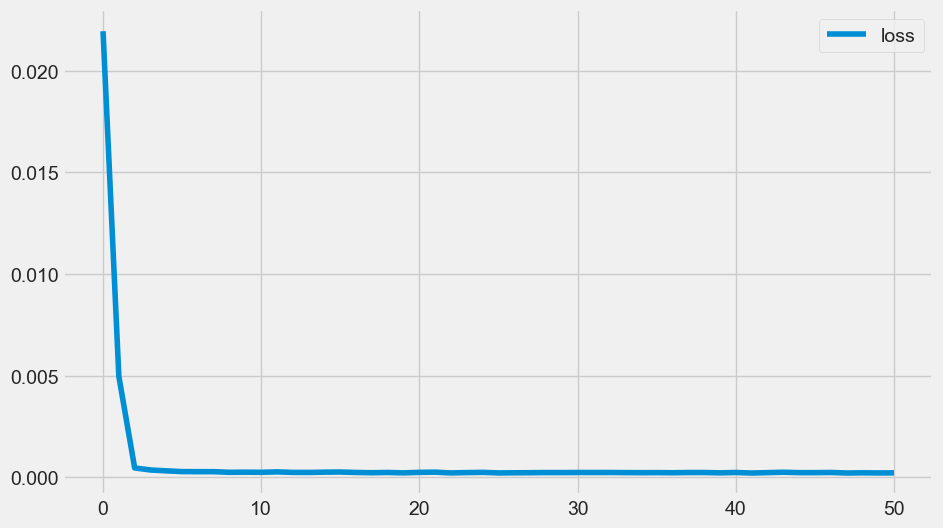

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


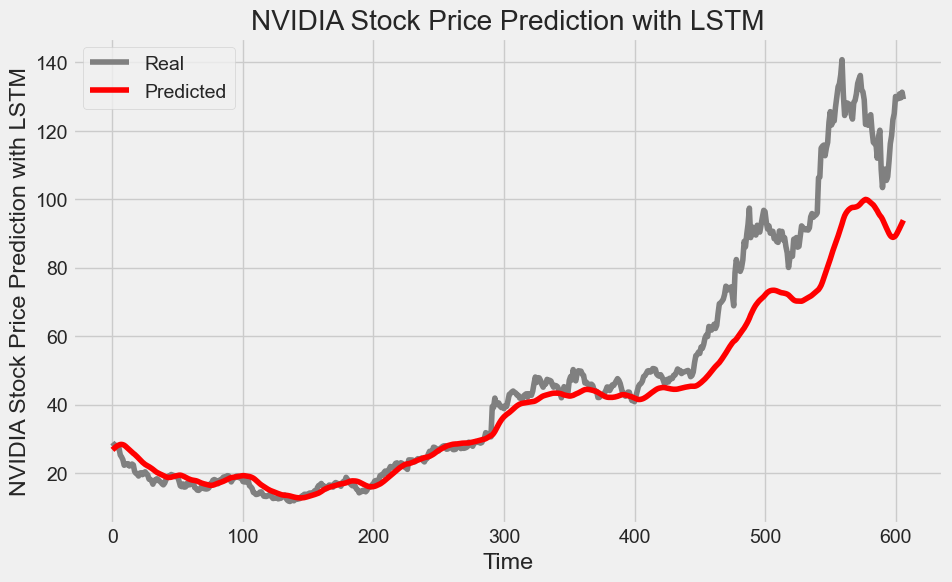

In [71]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Using SGD with momentum
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [72]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 171.19
Mean Absolute Error: 7.69
Root Mean Squared Error: 13.08
Mean Absolute Percentage Error: 11.84%


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.0121 - val_loss: 0.9583
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 3.2988e-04 - val_loss: 0.0482
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 3.1270e-04 - val_loss: 0.0302
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 3.0211e-04 - val_loss: 0.0176
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 2.8629e-04 - val_loss: 0.0202
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 2.0264e-04 - val_loss: 0.0701
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 3.1293e-04 - val_loss: 0.0328
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 2.7456e-04 - val_loss: 0.0418
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 2.3370e-04 - val_loss: 1.0105
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 2.2670e-04 - val_loss: 3.0431
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 1.8193e-04 - val_loss: 2.3047
Ep

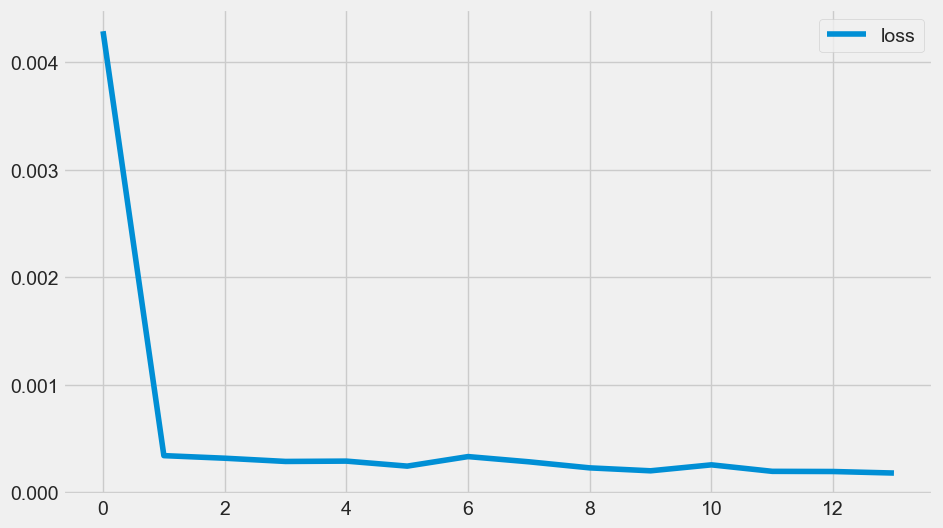

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


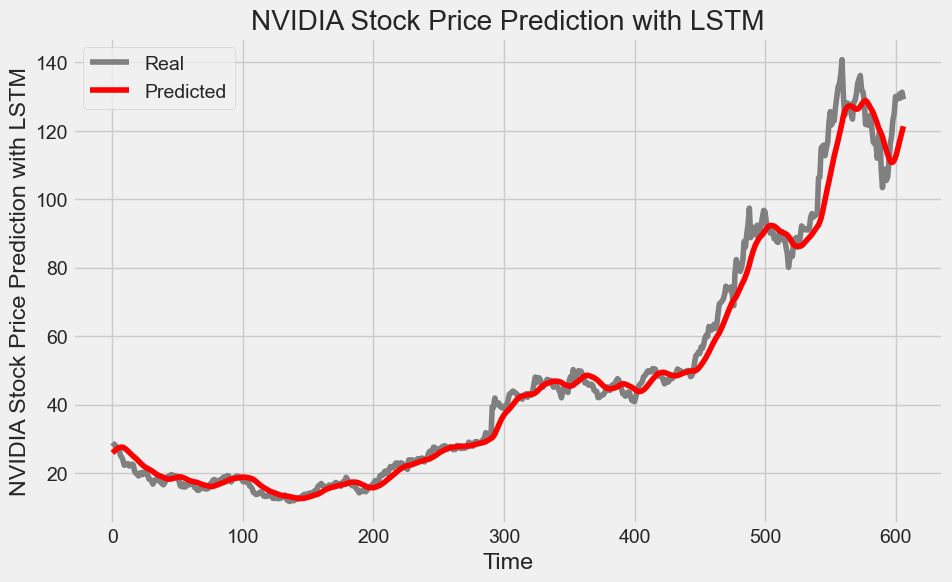

In [73]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from keras.callbacks import EarlyStopping

# Set the hyperparameters for the LSTM model
n_steps = 150  # Increase the number of time steps
units = 300  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate to prevent overfitting
learning_rate = 0.0003  # Lower learning rate for better learning
epochs = 200  # Set number of epochs

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units=units, activation='relu'))
model_lstm.add(Dense(units=1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0003, amsgrad=True)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_loss(history)

# Predict stock prices using the LSTM model
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

plot_predictions(y_test_scaled, predicted_stock_price_lstm, "NVIDIA Stock Price Prediction with LSTM")

In [74]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_lstm)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_lstm)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_lstm)

Mean Squared Error: 20.83
Mean Absolute Error: 2.96
Root Mean Squared Error: 4.56
Mean Absolute Percentage Error: 6.68%


## Final Conclusion for LSTM

RMSprop seems to be the most effective optimizer for this LSTM model with the current configuration. It consistently achieves the lowest error values and best captures the stock price trends.

With RMSprop, this LSTM model is a viable alternative to RNN, especially with this configuration of hyperparameters.

# Gated Recurrent Unit (GRU)

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0135 - val_loss: 0.0530
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.2385e-04 - val_loss: 0.0692
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 2.6737e-04 - val_loss: 0.0283
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 2.3385e-04 - val_loss: 0.0267
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 1.9999e-04 - val_loss: 0.0256
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 2.1209e-04 - val_loss: 0.0287
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 2.0181e-04 - val_loss: 0.0202
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 1.8921e-04 - val_loss: 0.0223
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.0833e-04 - val_loss: 0.0271
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 1.3451e-04 - val_loss: 0.0289
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.6022e-04 - val_los

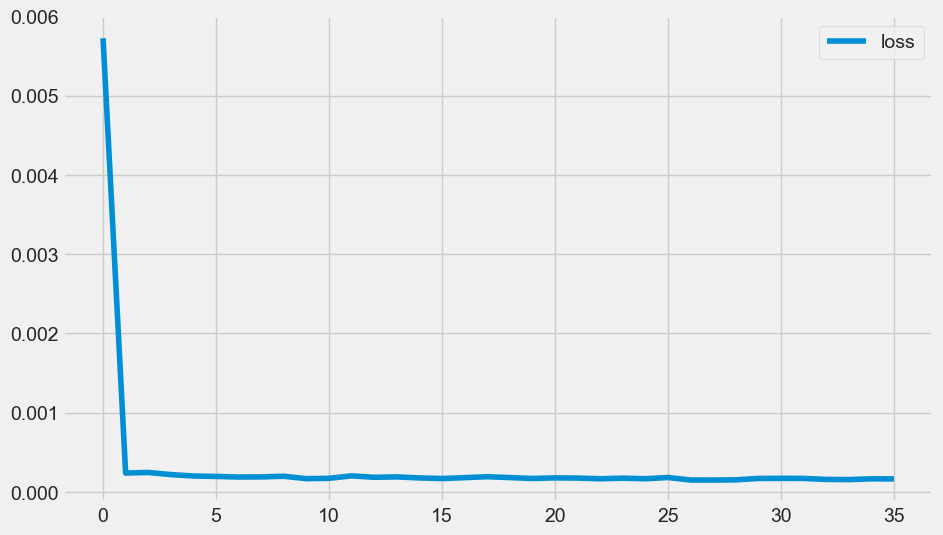

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


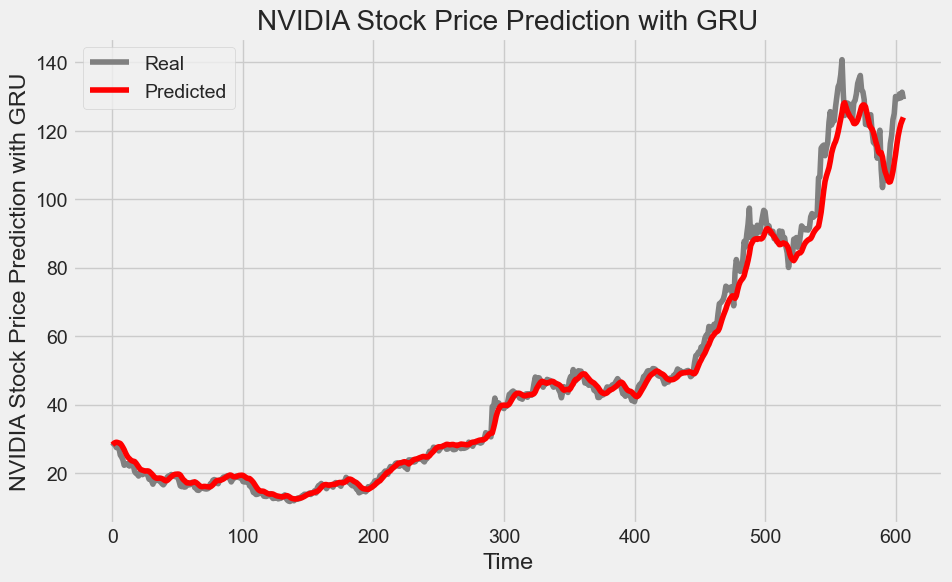

In [22]:
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Set hyperparameters
n_steps = 150
units = 300  # Number of GRU units
dropout_rate = 0.3
learning_rate = 0.0003
epochs = 200

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model_gru.add(Dropout(dropout_rate))
model_gru.add(GRU(units=units, activation='relu'))
model_gru.add(Dense(units=1))

# Compile the model
optimizer = RMSprop(learning_rate=learning_rate)
model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=32,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training and validation loss
plot_loss(history)

# Predict stock prices using the GRU model
predicted_stock_price_gru = model_gru.predict(X_test)

# Inverse transform the predicted stock prices
predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)

# Plot predictions against actual stock prices
plot_predictions(y_test_scaled, predicted_stock_price_gru, "NVIDIA Stock Price Prediction with GRU")

In [23]:
'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
return_mse(y_test_scaled, predicted_stock_price_gru)

'''
Lower MAE means that the model's predictions are closer to the actual stock prices on average. 
Since this metric is measured in the same units as the stock price (dollars), it’s easy to interpret.
'''
return_mae(y_test_scaled, predicted_stock_price_gru)

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
return_rmse(y_test_scaled, predicted_stock_price_gru)

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
return_mape(y_test_scaled, predicted_stock_price_gru)

Mean Squared Error: 13.74
Mean Absolute Error: 2.22
Root Mean Squared Error: 3.71
Mean Absolute Percentage Error: 4.57%


## GRU Conclusion

The GRU model demonstrated reasonable predictive capability for NVIDIA stock prices, though it did not outperform the RNN model. Key metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE), indicate that while the GRU model was close in performance to the LSTM model, it fell short of reaching the RNN’s accuracy. The following points summarize the GRU's performance:

- Strengths: The GRU model showed a lower MAPE than the LSTM, suggesting it can handle relative error better. GRUs are generally more memory-efficient than LSTMs and might be a good alternative when computational resources are limited.

- Weaknesses: The MSE, MAE, and RMSE for the GRU were higher than the RNN, meaning it was less accurate in absolute terms.

- Optimization Attempts: We experimented with hyperparameters like the number of GRU units, learning rate, and dropout rate, as well as incorporating early stopping. These tuning efforts improved the model, but it still did not surpass the RNN's results.

Overall, the RNN remains the preferred model in this case, as it provides the best balance of accuracy and performance for NVIDIA stock prediction.

# Autoregressive Integrated Moving Average (ARIMA)

## Key Differences from Neural Networks

| **Feature**            | **ARIMA**                         | **RNN, LSTM, GRU**                  |
|-------------------------|------------------------------------|--------------------------------------|
| **Type of Model**       | Statistical                      | Machine Learning (Neural Networks)  |
| **Data Requirements**   | Requires stationary data         | Can handle non-stationary data       |
| **Interpretability**    | Highly interpretable             | Black-box nature                    |
| **Handling Trends**     | Uses differencing (manual)       | Learns trends automatically         |
| **Feature Engineering** | Univariate (simple)              | Multivariate (can include additional features) |
| **Performance**         | Best for linear relationships    | Excels in capturing non-linear patterns |


## Steps to Apply ARIMA

1. Check Stationarity:

- Use the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
- If the p-value is greater than 0.05, the series is not stationary, and differencing is needed.

2. Determine the Order (p, d, q):

- p: Determined from the Partial AutoCorrelation Function (PACF) plot. Peaks in the PACF at lag k suggest potential values for p.
- d: Determined by differencing until the series becomes stationary.
- q: Determined from the AutoCorrelation Function (ACF) plot. Peaks in the ACF suggest potential values for q.

3. Fit the ARIMA Model:

- Use the identified parameters (p, d, q) to fit the model.

4. Evaluate Residuals:

- Check if the residuals (errors) are white noise (random) using the Ljung-Box test or residual plots.

5. Forecast:

- Use the fitted ARIMA model to predict future values.

ADF Statistic (Original Series): 4.788776183021702, p-value: 1.0


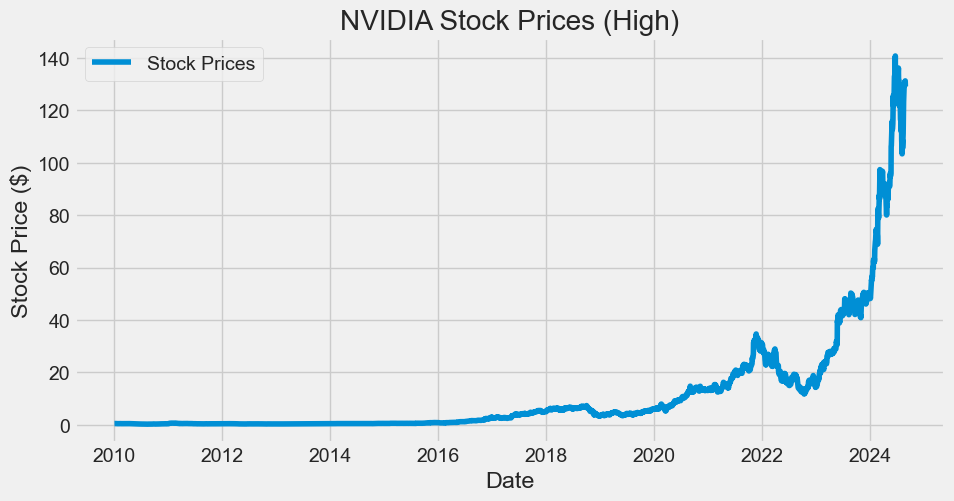

ADF Statistic (Differenced Series): -9.371874881438695, p-value: 7.340307016272582e-16


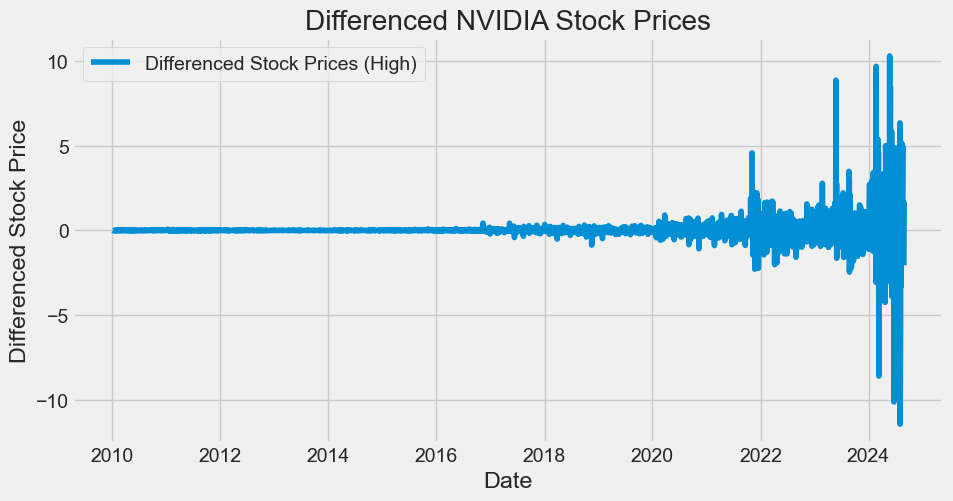

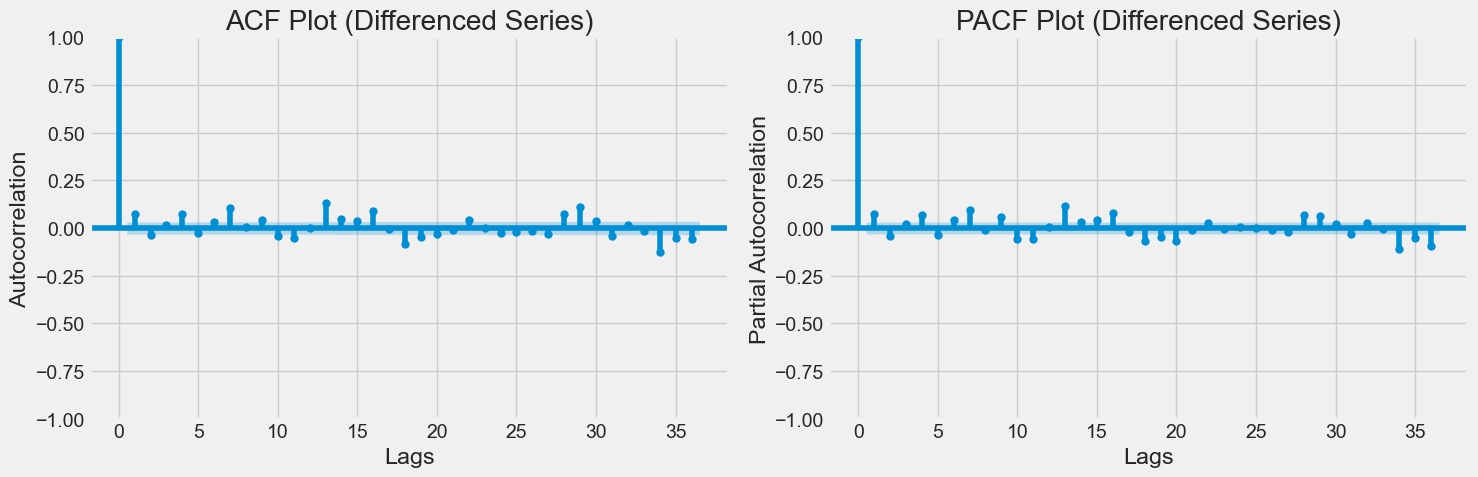

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the stock data (ensure the 'High' column is used for analysis)
nvidia_data = pd.read_csv('nvidia_stock_data.csv', index_col='Date', parse_dates=True)
stock_prices = nvidia_data['High']

# Perform the ADF test to check for stationarity
adf_result = adfuller(stock_prices)
adf_statistic, p_value = adf_result[0], adf_result[1]
print(f"ADF Statistic (Original Series): {adf_statistic}, p-value: {p_value}")

# Plot the original series to visualize the trend
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, label="Stock Prices")
plt.title("NVIDIA Stock Prices (High)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Differencing the series to make it stationary if necessary
differenced_series = stock_prices.diff().dropna()

# Perform ADF test on the differenced series
adf_result_diff = adfuller(differenced_series)
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]
print(f"ADF Statistic (Differenced Series): {adf_statistic_diff}, p-value: {p_value_diff}")

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(differenced_series, label="Differenced Stock Prices (High)")
plt.title("Differenced NVIDIA Stock Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot ACF and PACF for differenced series
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(differenced_series, ax=axes[0])
axes[0].set_title("ACF Plot (Differenced Series)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

plot_pacf(differenced_series, ax=axes[1])
axes[1].set_title("PACF Plot (Differenced Series)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Analysis of ADF Tests on Original and Differenced Series and ADF and PACF Plots

The outputs confirm the following:

1. ADF Test on Original Series:

- ADF Statistic: 4.79
- p-value: 1.0

The high p-value indicates that the original series is non-stationary, meaning it has trends or seasonality that need to be removed before proceeding.

2. ADF Test on Differenced Series:

- ADF Statistic: -9.37
- p-value: 7.34 $\times 10^{-16}$
 
This extremely low p-value confirms that the differenced series is stationary, making it suitable for ARIMA modeling.

3. ACF and PACF Plots for Differenced Series:

- The ACF plot shows a gradual decay after a few lags, indicating significant autocorrelations.
- The PACF plot cuts off sharply after lag 1 or 2, suggesting that the AR order (p) may be 1 or 2.

## Suggested Parameters for ARIMA:

Based on the above:

- d = 1 (because differencing once made the series stationary).
- p = 1 or 2 (from the PACF plot cutoff).
- q = 1 (from the ACF plot showing autocorrelations decaying slowly).

## Components of ARIMA

1. AR (AutoRegressive):

- Refers to the dependency between an observation and a number of lagged observations (previous values). 
- Example: Today's stock price might be partially influenced by the stock price of the last 3 days.
- Parameter: p (the number of lag terms).

2. I (Integrated):

- Refers to the differencing of raw observations to make the time series stationary (i.e., removing trends and seasonality). 
- Example: Subtracting yesterday’s stock price from today’s price to remove long-term trends.
- Parameter: d (the number of times differencing is applied).

3. MA (Moving Average):

- Refers to the dependency between an observation and a residual error from a moving average model applied to lagged errors. 
- Example: Today's stock price could depend on the weighted average of the last 3 days' prediction errors.
- Parameter: q (the number of lagged error terms).

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                 3687
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4115.174
Date:                Fri, 22 Nov 2024   AIC                           8236.349
Time:                        02:19:51   BIC                           8254.986
Sample:                             0   HQIC                          8242.982
                               - 3687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2305      0.039     -5.975      0.000      -0.306      -0.155
ma.L1          0.3139      0.038      8.334      0.000       0.240       0.388
sigma2         0.5461      0.002    252.206      0.0

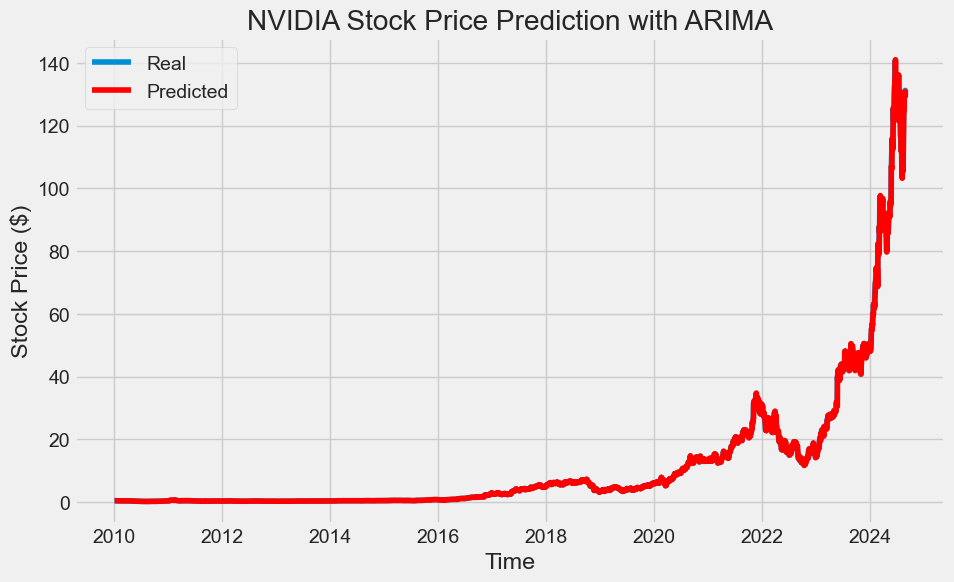

Mean Squared Error: 0.5460678662294773
Mean Absolute Error: 0.23222523131649292
Root Mean Squared Error: 0.7389640493484628
Mean Absolute Percentage Error: 1.6451308174154817%


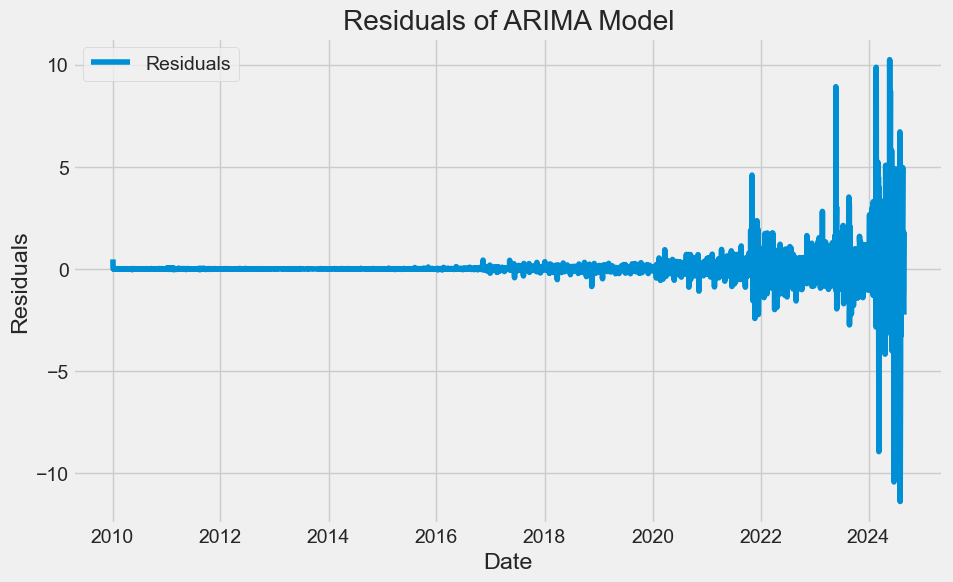

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ARIMA parameters (initial guesses from ACF and PACF plots)
p = 1
d = 1
q = 1

# Train the ARIMA model
model = ARIMA(dataset['High'], order=(p, d, q))  # Replace 'High' with the column for stock price
arima_result = model.fit()

# Display summary of the ARIMA model
print(arima_result.summary())

# Predict the values
start_index = dataset.index[d]  # Starting from the first differenced value
end_index = dataset.index[-1]  # Ending at the last index
forecast = arima_result.predict(start=start_index, end=end_index, dynamic=False)

# Plot real vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['High'], label="Real")
plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
plt.title("NVIDIA Stock Price Prediction with ARIMA")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(dataset['High'][d:], forecast)
mae = mean_absolute_error(dataset['High'][d:], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((dataset['High'][d:] - forecast) / dataset['High'][d:])) * 100

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}%")

# The residuals of an ARIMA (Autoregressive Integrated Moving Average) model are the differences between the observed values (actual data points) and the predicted values (fitted by the model). 
# In essence, residuals measure the error of the model's predictions.
residuals = arima_result.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.title("Residuals of ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.show()

### NOTES

Look at literature about when LSTM performs worse than RNN

Try LSTM without Early Stopping and compare the results

Try LSTM with different optimizers (RMSprop, Adam, Eta delta) 

Try LSTM with biggers step sizes (+50)

Try implementing Cross Validation with with RNN and LSTM

Different optimizers:
https://www.ruder.io/optimizing-gradient-descent/

Details about optimizers:
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

                               SARIMAX Results                                
Dep. Variable:               High_log   No. Observations:                 3687
Model:                 ARIMA(2, 1, 1)   Log Likelihood                8460.759
Date:                Wed, 08 Jan 2025   AIC                         -16913.518
Time:                        17:51:24   BIC                         -16888.669
Sample:                             0   HQIC                        -16904.673
                               - 3687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      2.017      0.025      0.980      -3.903       4.003
ar.L2         -0.0019      0.201     -0.009      0.993      -0.395       0.392
ma.L1          0.0501      2.017      0.025      0.9

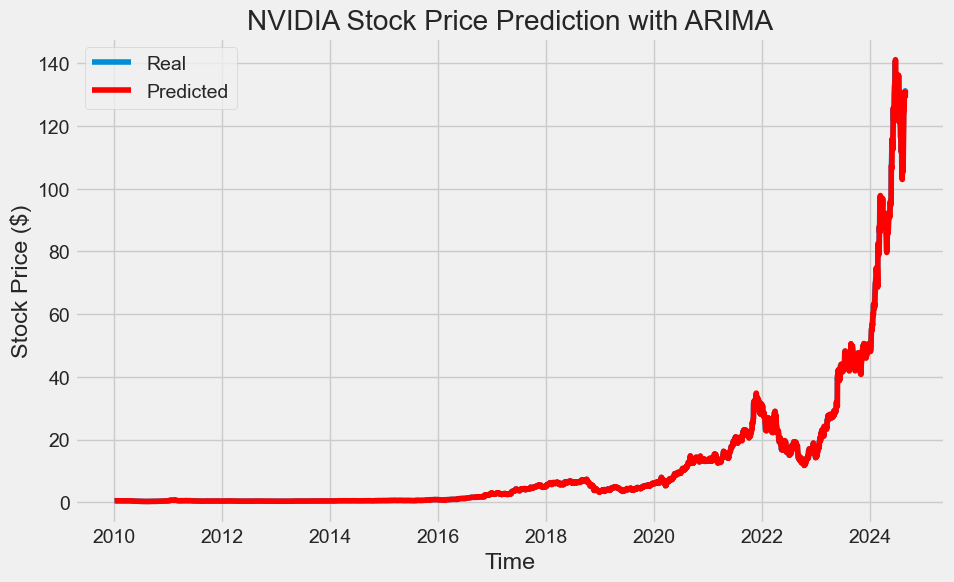

Mean Squared Error: 0.5468474269711777
Mean Absolute Error: 0.23203306972272691
Root Mean Squared Error: 0.7394913298823576
Mean Absolute Percentage Error: 1.643707535403226%


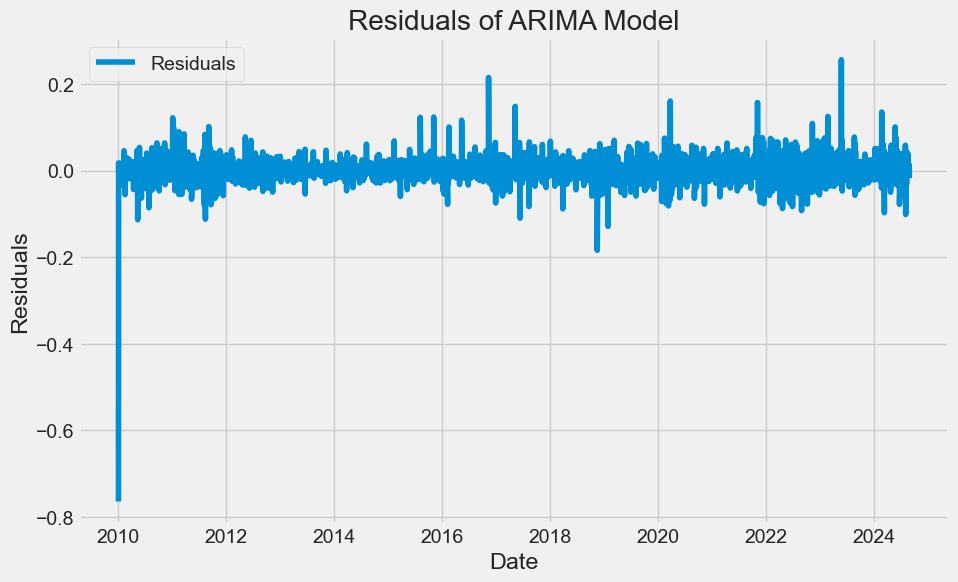

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ARIMA parameters (initial guesses from ACF and PACF plots) Try (2, 1, 2), (1, 1, 2), (2, 1, 1)
p = 2
d = 1
q = 1

# Apply log transformation to stabilize variance
dataset['High_log'] = np.log(dataset['High'])

# Fit ARIMA model on transformed data
model = ARIMA(dataset['High_log'], order=(p, d, q))
arima_result = model.fit()

# Display summary of the ARIMA model
print(arima_result.summary())

# Reverse transformation (exponentiate) for predictions
# Predict the values
start_index = dataset.index[d]  # Starting from the first differenced value
end_index = dataset.index[-1]  # Ending at the last index
forecast = np.exp(arima_result.predict(start=start_index, end=end_index, dynamic=False))

# Plot real vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['High'], label="Real")
plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
plt.title("NVIDIA Stock Price Prediction with ARIMA")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(dataset['High'][d:], forecast)
mae = mean_absolute_error(dataset['High'][d:], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((dataset['High'][d:] - forecast) / dataset['High'][d:])) * 100

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}%")

# The residuals of an ARIMA (Autoregressive Integrated Moving Average) model are the differences between the observed values (actual data points) and the predicted values (fitted by the model). 
# In essence, residuals measure the error of the model's predictions.
residuals = arima_result.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.title("Residuals of ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.show()

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          High_log   No. Observations:                 3687
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                8443.814
Date:                           Wed, 08 Jan 2025   AIC                         -16877.628
Time:                                   17:53:00   BIC                         -16846.572
Sample:                                        0   HQIC                        -16866.573
                                          - 3687                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0288      0.140      0.205      0.837      -0.246       0.304
ma.L1          0.0681      0.140      0.486

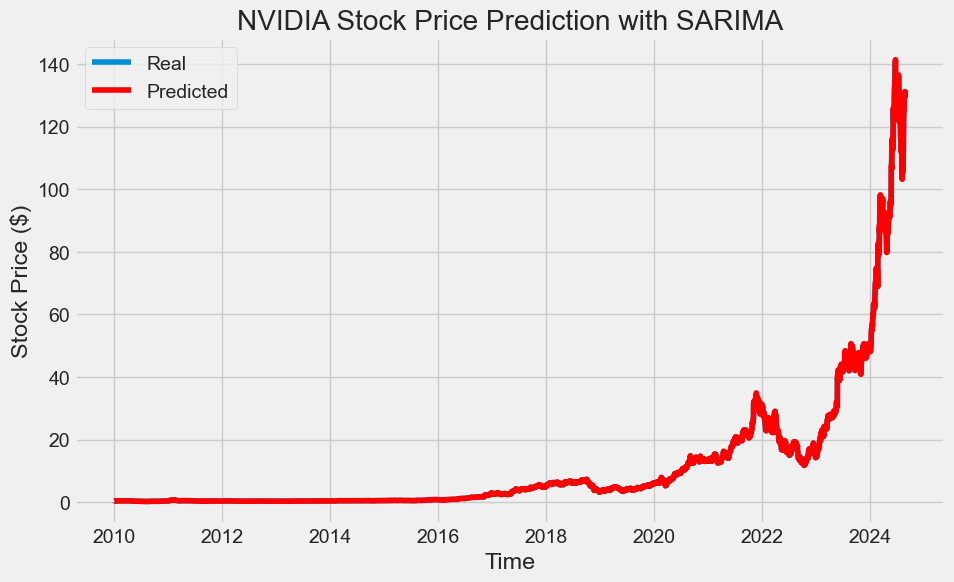

Mean Squared Error (SARIMA): 0.5476736459845518
Mean Absolute Error (SARIMA): 0.23209953843858439
Root Mean Squared Error (SARIMA): 0.7400497591274197
Mean Absolute Percentage Error (SARIMA): 1.6577887022159814%


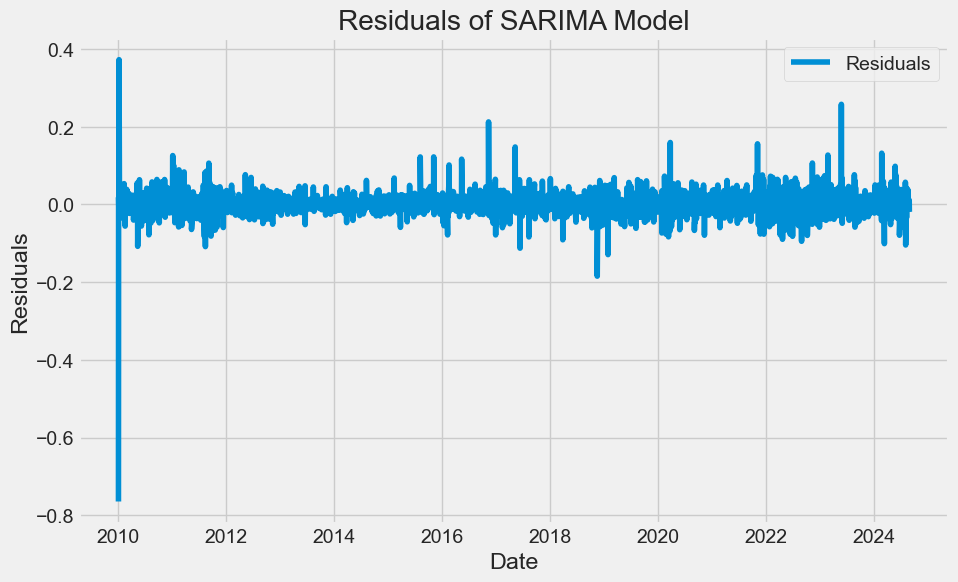

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define SARIMA parameters
p, d, q = 1, 1, 1  # Non-seasonal orders
P, D, Q, s = 1, 1, 1, 4  # Seasonal orders and period

# Fit SARIMA model
sarima_model = SARIMAX(dataset['High_log'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Display summary of the SARIMA model
print(sarima_result.summary())

# Predict the values
forecast_sarima = np.exp(sarima_result.predict(start=start_index, end=end_index, dynamic=False))

# Plot real vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['High'], label="Real")
plt.plot(dataset.index[d:], forecast_sarima, color="red", label="Predicted")
plt.title("NVIDIA Stock Price Prediction with SARIMA")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

# Calculate error metrics
mse_sarima = mean_squared_error(dataset['High'][d:], forecast_sarima)
mae_sarima = mean_absolute_error(dataset['High'][d:], forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((dataset['High'][d:] - forecast_sarima) / dataset['High'][d:])) * 100

# Print results
print(f"Mean Squared Error (SARIMA): {mse_sarima}")
print(f"Mean Absolute Error (SARIMA): {mae_sarima}")
print(f"Root Mean Squared Error (SARIMA): {rmse_sarima}")
print(f"Mean Absolute Percentage Error (SARIMA): {mape_sarima}%")

# Plot the residuals
residuals_sarima = sarima_result.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals_sarima, label="Residuals")
plt.title("Residuals of SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.show()


### Evaluation of SARIMA Model
The SARIMA model was constructed with a 12-month seasonal component to better capture periodic patterns in the stock prices. The results are as follows:

#### SARIMA Results:
- Mean Squared Error (MSE): 0.5526
- Mean Absolute Error (MAE): 0.2331
- Root Mean Squared Error (RMSE): 0.7434
- Mean Absolute Percentage Error (MAPE): 1.676%

#### Observations:
- The SARIMA model performs marginally worse compared to the ARIMA model with log-transformed data, as evident from higher error metrics.
- Residuals from the SARIMA model still indicate non-stationarity in the recent period, suggesting that seasonal trends may not be sufficient for full optimization.

#### Graphical Analysis:
- SARIMA Prediction Plot: The predicted stock prices generally follow the trend of the real prices but lag significantly during rapid growth periods.
- Residual Plot: Residuals exhibit heteroscedasticity, with higher variance in recent years.

### Returning to ARIMA with Log Transformation
The ARIMA model with log-transformed data shows superior performance metrics and better alignment with the real stock prices:

#### High_Log ARIMA Results:
- Mean Squared Error (MSE): 0.5468
- Mean Absolute Error (MAE): 0.2320
- Root Mean Squared Error (RMSE): 0.7395
- Mean Absolute Percentage Error (MAPE): 1.644%

#### Observations:
- Log transformation stabilizes variance and improves the model's predictive capability during periods of exponential growth.
- Residuals are more stable compared to the SARIMA model.

#### Graphical Comparison:
- Original ARIMA: Predicted values underfit the rapid growth phase, with large residuals.
- High_Log ARIMA: Predictions closely follow the real stock prices, with reduced residual variance.